In [1]:
import os
import numpy as np

from tianshou.policy import DDPGPolicy
from tianshou.utils.net.common import Net
from tianshou.exploration import GaussianNoise
from tianshou.trainer import offpolicy_trainer
from tianshou.utils.net.continuous import Actor, Critic
from tianshou.data import Collector, ReplayBuffer, VectorReplayBuffer, to_numpy
import torch
import datetime
import pickle
import matplotlib.pyplot as plt



In [2]:
from CF_env import CFEnv

usedRewardFunction = 'equilibrium_spacing_embedded'

env = CFEnv(usedRewardFunction)
train_envs = CFEnv(usedRewardFunction)
test_envs = CFEnv(usedRewardFunction)


state_shape = env.observation_space.shape 
action_shape = env.action_space.shape
print("Observations shape:", state_shape)
print("Actions shape:", action_shape)
print(env.rewardName)

Observations shape: (3,)
Actions shape: (1,)
equilibrium_spacing_embedded


In [3]:

resume_path = None

seed = 1
actor_lr = 1e-4
critic_lr = 1e-3
tau = .001
gamma = .99
exploration_noise = .15
buffer_size = 100000
batch_size = 256

# seed
np.random.seed(seed)
torch.manual_seed(seed)
train_envs.seed(seed)
test_envs.seed(seed)

# model
net_a = Net(state_shape, hidden_sizes=[256, 256], device='cuda' if torch.cuda.is_available() else 'cpu')
actor = Actor(net_a, action_shape, device='cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    actor = actor.to('cuda')
actor_optim = torch.optim.Adam(actor.parameters(), lr=actor_lr)

net_c = Net(state_shape, action_shape,
            hidden_sizes=[256, 256],
            concat=True, device='cuda' if torch.cuda.is_available() else 'cpu')
critic = Critic(net_c, device='cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    critic = critic.to('cuda')
critic_optim = torch.optim.Adam(critic.parameters(), lr=critic_lr)

policy = DDPGPolicy(
    actor, actor_optim, critic, critic_optim,
    tau=tau, gamma=gamma,
    exploration_noise=GaussianNoise(sigma=exploration_noise),
    estimation_step=1, action_space=action_shape)

# load a previous policy
if resume_path:
    policy.load_state_dict(torch.load(resume_path, map_location='cuda' if torch.cuda.is_available() else 'cpu'))
    print("Loaded agent from: ", resume_path)

# collector

buffer = ReplayBuffer(buffer_size)
train_collector = Collector(policy, train_envs, buffer, exploration_noise=True)
test_collector = Collector(policy, test_envs)
train_collector.collect(n_step=buffer_size // 4, random=True)

# log
t0 = datetime.datetime.now().strftime("%m%d_%H%M%S")
log_file = f'seed_{seed}_{t0}_ddpg'
log_path = os.path.join('log', 'ddpg')
if not os.path.exists(log_path):
    os.makedirs(log_path)
print(log_file)

def save_fn(policy):
    torch.save(policy.state_dict(), os.path.join(log_path, log_file + '_policy.pth'))
    
# trainer
result = offpolicy_trainer(
    policy, train_collector, test_collector, max_epoch=15,
    step_per_epoch=10000, step_per_collect=1, episode_per_test= 1,
    batch_size=batch_size, save_fn=save_fn,
    update_per_step=1, test_in_train=False)

# Let's watch its performance!
# print('\n start testing')
# policy.eval()
# test_envs.seed(seed)
# test_collector.reset()
# result = test_collector.collect(n_episode=1)
# print(f'Final reward: {result["rews"].mean()}, length: {result["lens"].mean()}')

#save policy
# torch.save(policy.state_dict(), os.path.join(log_path, log_file + '_policy.pth'))

Epoch #1:   0%|          | 0/10000 [00:00<?, ?it/s]

seed_1_0521_130402_ddpg


Epoch #1: 10001it [02:01, 82.35it/s, env_step=10000, len=1614, loss/actor=7068.350, loss/critic=339626.210, n/ep=0, n/st=1, rew=-3175281.31]                           
Epoch #2:   0%|          | 15/10000 [00:00<01:57, 85.26it/s, env_step=10015, len=1614, loss/actor=7073.709, loss/critic=282124.476, n/ep=0, n/st=1, rew=-3175281.31]

Epoch #1: test_reward: -3167989.250000 ± 0.000000, best_reward: -1734.443604 ± 0.000000 in #0


Epoch #2: 10001it [02:01, 82.15it/s, env_step=20000, len=1614, loss/actor=18102.663, loss/critic=1735311.089, n/ep=0, n/st=1, rew=-3168210.75]                           
Epoch #3:   0%|          | 16/10000 [00:00<01:49, 91.11it/s, env_step=20016, len=1614, loss/actor=18162.998, loss/critic=1715453.261, n/ep=0, n/st=1, rew=-3168210.75]

Epoch #2: test_reward: -3167989.250000 ± 0.000000, best_reward: -1734.443604 ± 0.000000 in #0


Epoch #3: 10001it [02:01, 82.36it/s, env_step=30000, len=78, loss/actor=24346.995, loss/critic=2258584.781, n/ep=0, n/st=1, rew=-1808.23]                               
Epoch #4:   0%|          | 16/10000 [00:00<01:51, 89.60it/s, env_step=30016, len=78, loss/actor=24449.714, loss/critic=2666436.591, n/ep=0, n/st=1, rew=-1808.23]

Epoch #3: test_reward: -1734.888306 ± 0.000000, best_reward: -1734.443604 ± 0.000000 in #0


Epoch #4: 10001it [02:02, 81.89it/s, env_step=40000, len=80, loss/actor=25998.000, loss/critic=1322994.824, n/ep=0, n/st=1, rew=-2260.01]                           
Epoch #5:   0%|          | 15/10000 [00:00<01:56, 85.75it/s, env_step=40015, len=80, loss/actor=26196.247, loss/critic=2447584.313, n/ep=0, n/st=1, rew=-2260.01]

Epoch #4: test_reward: -1828.383545 ± 0.000000, best_reward: -1734.443604 ± 0.000000 in #0


Epoch #5: 10001it [02:02, 81.52it/s, env_step=50000, len=82, loss/actor=27151.842, loss/critic=6496786.438, n/ep=0, n/st=1, rew=-1811.52]                           
Epoch #6:   0%|          | 15/10000 [00:00<01:57, 85.07it/s, env_step=50015, len=82, loss/actor=27300.677, loss/critic=4097952.033, n/ep=0, n/st=1, rew=-1811.52]

Epoch #5: test_reward: -1553.031250 ± 0.000000, best_reward: -1553.031250 ± 0.000000 in #5


Epoch #6: 10001it [02:02, 81.57it/s, env_step=60000, len=79, loss/actor=27245.807, loss/critic=2450845.512, n/ep=0, n/st=1, rew=-1703.84]                           
Epoch #7:   0%|          | 16/10000 [00:00<01:49, 91.45it/s, env_step=60016, len=79, loss/actor=27093.843, loss/critic=2454873.883, n/ep=0, n/st=1, rew=-1703.84]

Epoch #6: test_reward: -3435.876465 ± 0.000000, best_reward: -1553.031250 ± 0.000000 in #5


Epoch #7: 10001it [02:03, 80.89it/s, env_step=70000, len=79, loss/actor=26666.905, loss/critic=4725734.479, n/ep=0, n/st=1, rew=-1759.94]                           
Epoch #8:   0%|          | 15/10000 [00:00<01:58, 84.29it/s, env_step=70015, len=79, loss/actor=26776.134, loss/critic=7785570.487, n/ep=0, n/st=1, rew=-1759.94]

Epoch #7: test_reward: -1710.113159 ± 0.000000, best_reward: -1553.031250 ± 0.000000 in #5


Epoch #8: 10001it [02:07, 78.73it/s, env_step=80000, len=79, loss/actor=26890.166, loss/critic=5212366.246, n/ep=0, n/st=1, rew=-1759.82]                           
Epoch #9:   0%|          | 15/10000 [00:00<01:57, 84.91it/s, env_step=80015, len=79, loss/actor=26886.868, loss/critic=5296817.458, n/ep=0, n/st=1, rew=-1759.82]

Epoch #8: test_reward: -1730.285889 ± 0.000000, best_reward: -1553.031250 ± 0.000000 in #5


Epoch #9: 10001it [02:10, 76.77it/s, env_step=90000, len=78, loss/actor=27638.561, loss/critic=11687891.089, n/ep=0, n/st=1, rew=-2014.00]                           
Epoch #10:   0%|          | 15/10000 [00:00<01:57, 85.34it/s, env_step=90015, len=78, loss/actor=27722.678, loss/critic=7885079.143, n/ep=0, n/st=1, rew=-2014.00]

Epoch #9: test_reward: -1720.854492 ± 0.000000, best_reward: -1553.031250 ± 0.000000 in #5


Epoch #10: 10001it [28:10,  5.92it/s, env_step=100000, len=80, loss/actor=27156.289, loss/critic=7952292.368, n/ep=0, n/st=1, rew=-2026.79]                            
Epoch #11:   0%|          | 13/10000 [00:00<02:12, 75.37it/s, env_step=100013, len=80, loss/actor=27221.421, loss/critic=4336811.101, n/ep=0, n/st=1, rew=-2026.79]

Epoch #10: test_reward: -1042.434326 ± 0.000000, best_reward: -1042.434326 ± 0.000000 in #10


Epoch #11: 10001it [02:22, 70.03it/s, env_step=110000, len=76, loss/actor=17854.664, loss/critic=2351313.587, n/ep=0, n/st=1, rew=-1878.39]                           
Epoch #12:   0%|          | 13/10000 [00:00<02:09, 77.28it/s, env_step=110013, len=76, loss/actor=17497.371, loss/critic=2359270.188, n/ep=0, n/st=1, rew=-1878.39]

Epoch #11: test_reward: -1734.888306 ± 0.000000, best_reward: -1042.434326 ± 0.000000 in #10


Epoch #12: 10001it [02:18, 72.34it/s, env_step=120000, len=78, loss/actor=5600.924, loss/critic=2588254.859, n/ep=0, n/st=1, rew=-1812.62]                            
Epoch #13:   0%|          | 16/10000 [00:00<01:44, 95.61it/s, env_step=120016, len=78, loss/actor=5827.276, loss/critic=2588684.997, n/ep=0, n/st=1, rew=-1812.62]

Epoch #12: test_reward: -1734.888306 ± 0.000000, best_reward: -1042.434326 ± 0.000000 in #10


Epoch #13: 10001it [02:28, 67.29it/s, env_step=130000, len=98, loss/actor=820.155, loss/critic=1569.471, n/ep=0, n/st=1, rew=-2440.15]                              
Epoch #14:   0%|          | 15/10000 [00:00<01:52, 88.81it/s, env_step=130015, len=98, loss/actor=820.090, loss/critic=1655.892, n/ep=0, n/st=1, rew=-2440.15]

Epoch #13: test_reward: -2633.139893 ± 0.000000, best_reward: -1042.434326 ± 0.000000 in #10


Epoch #14: 10001it [02:22, 70.00it/s, env_step=140000, len=80, loss/actor=831.757, loss/critic=210522.271, n/ep=0, n/st=1, rew=-1867.03]                           
Epoch #15:   0%|          | 13/10000 [00:00<02:12, 75.14it/s, env_step=140013, len=80, loss/actor=831.820, loss/critic=210062.021, n/ep=0, n/st=1, rew=-1867.03]

Epoch #14: test_reward: -1705.349854 ± 0.000000, best_reward: -1042.434326 ± 0.000000 in #10


Epoch #15: 10001it [02:39, 62.78it/s, env_step=150000, len=78, loss/actor=841.669, loss/critic=872.329, n/ep=0, n/st=1, rew=-1636.60]                             


Epoch #15: test_reward: -1800.298584 ± 0.000000, best_reward: -1042.434326 ± 0.000000 in #10


In [4]:
# this is for plotting the dynamic of reward during evaluation (not plotting now for this version)
# needs to be modified corresponding when the reward function in the training part is changed.
# ideally this process should be automatic (to update)
def get_reward(acceleration, newSpacing, follower_speed, leader_speed):
    newTimeGap = newSpacing / (follower_speed + .001)
    expected_speed = 33.5
    expected_time_gap = 1
    alpha = 1
    beta = 1
    gamma = 1
    delta = 4
    reward = 0
    
    # time headway
    penalty1 = [[0]]
    if expected_time_gap > newTimeGap > 0:
        penalty1 = - alpha * (100 - 100 * np.sqrt(max(0, expected_time_gap-(expected_time_gap-newTimeGap)**2)))
        reward += penalty1

    # speed reward
    reward2 = beta * min(expected_speed, follower_speed)
    reward += reward2

    #speed diff reward
    reward3 = [[0]]
    if newTimeGap < expected_time_gap and leader_speed > follower_speed:
        reward3 = gamma * (leader_speed - follower_speed) * (expected_time_gap - newTimeGap)
        reward += reward3
        
    penalty4 = - delta * acceleration ** 2
    reward += penalty4

    return reward, penalty1, reward2, reward3, penalty4

In [6]:
policy.load_state_dict(torch.load(os.path.join(os.getcwd(), log_path, log_file + '_policy.pth'), 
                                  map_location='cuda' if torch.cuda.is_available() else 'cpu'))
print("Loaded agent from: ", log_file)
policy.eval()
rewardHist = [[np.nan] * 4]

from CF_env import vehicle
SIM_RESOLUTION = .1
USED_HISTORY_STAMP  = 1
leadSpeedProfile = np.genfromtxt('test_leader_high.csv', delimiter=',')
leaderLoc = [0]
followerLoc = [-30]
for v in leadSpeedProfile[1:USED_HISTORY_STAMP]:
    leaderLoc.append(leaderLoc[-1] + v * SIM_RESOLUTION)
    followerLoc.append(followerLoc[-1] + v * SIM_RESOLUTION)
follower = vehicle(leadSpeedProfile[:USED_HISTORY_STAMP], followerLoc)
leader = vehicle(leadSpeedProfile[:USED_HISTORY_STAMP], leaderLoc)
followerSpeedProfile = leadSpeedProfile[:USED_HISTORY_STAMP]
followerSpacing = np.array([30] * USED_HISTORY_STAMP)
observation = np.concatenate((leader.speedT, follower.speedT,
                          [leader.locT[i] - follower.locT[i] for i in range(USED_HISTORY_STAMP)]))

t = USED_HISTORY_STAMP
while True:
    with torch.no_grad():  
        obs = np.array([observation])
        result = policy.actor(obs)
    act = to_numpy(result[0])
    action = policy.map_action(act)
    
    follower.action_a(action)
    leader.action_v(leadSpeedProfile[t])
    newSpacing = leader.location - follower.location
    newStates = np.concatenate((leader.speedT, follower.speedT,
                          [leader.locT[i] - follower.locT[i] for i in range(USED_HISTORY_STAMP)]))
    followerSpeedProfile = np.append(followerSpeedProfile, [follower.speed])
    followerSpacing = np.append(followerSpacing, newSpacing)
    reward, penalty1, reward2, reward3, penalty4 = get_reward(action, 
                                                              newSpacing, 
                                                              follower.speed, 
                                                              leader.speed)
#     rewardHist.append([i[0][0] for i in [penalty1, reward2, reward3, penalty4]])
    #current obs
    t += 1
    observation = newStates
    if newSpacing < 0 or t >= len(leadSpeedProfile):
        done = 1
    else:
        done = 0
        
    if done:
        break




Loaded agent from:  seed_1_0521_130402_ddpg


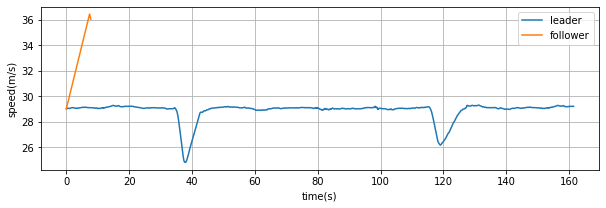

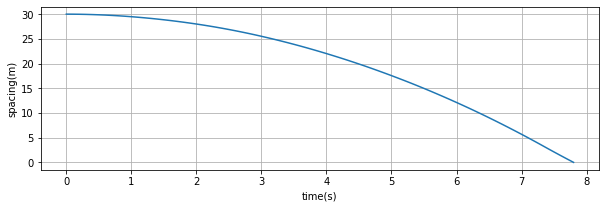

In [7]:

plt.figure(figsize = (10, 3))
plt.plot(np.arange(len(leadSpeedProfile)) / 10, leadSpeedProfile, label = 'leader')
plt.plot(np.arange(len(followerSpeedProfile)) / 10, followerSpeedProfile, label = 'follower')
plt.xlabel('time(s)')
plt.ylabel('speed(m/s)')
# plt.ylim(22.5, 32.5)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize = (10, 3))
plt.plot(np.arange(len(followerSpeedProfile)) / 10, followerSpacing)
plt.xlabel('time(s)')
plt.ylabel('spacing(m)')
plt.grid(True)
# plt.ylim(20, 45)

plt.show()



In [8]:
print(round(min(followerSpeedProfile[:1000]),2), round(min(followerSpeedProfile[1000:]),2))

ValueError: min() arg is an empty sequence

In [9]:
file = open(os.path.join(log_path, log_file + 'trajInfo'), 'wb')
pickle.dump([leadSpeedProfile, followerSpeedProfile, followerSpacing], file)
file.close()